In [1]:
%matplotlib notebook

In [2]:
import os
import sys
import numpy as np

In [3]:
import matplotlib.pyplot as plt
from matplotlib import ticker
from mpl_toolkits.mplot3d.axes3d import Axes3D
plt.ioff()

In [4]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [5]:
import data.analysis_tools as tools

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [7]:
from keras.models import Model
from keras.layers import Input, Dense
from keras.callbacks import TensorBoard, EarlyStopping

Using TensorFlow backend.


### Data Preparation

In [8]:
X_raw = np.load(os.path.abspath('raw/cat_mouse/X.npy'))[2:,]
Y_raw = np.load(os.path.abspath('raw/cat_mouse/Y.npy'))

In [9]:
print(X_raw.shape)
print(Y_raw.shape)

(2, 11, 11)
(11, 11)


In [10]:
X_full = X_raw.reshape(2, 121).T
Y_full = Y_raw.reshape(121, 1)

In [11]:
print(X_full.shape)
print(Y_full.shape)

(121, 2)
(121, 1)


In [12]:
np.array_equal(X_raw, X_full.T.reshape(2, 11, 11))

True

In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(X_full,
                                                    Y_full,
                                                    test_size=0.10)

### ML Modeling

In [14]:
visible = Input(shape=(2,), name="input")

hidden1 = Dense(64, activation='relu', name="hidden1")(visible)

output = Dense(1, activation='sigmoid', name="ouput")(hidden1)

In [15]:
model = Model(inputs=visible, outputs=output)

In [16]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 2)                 0         
_________________________________________________________________
hidden1 (Dense)              (None, 64)                192       
_________________________________________________________________
ouput (Dense)                (None, 1)                 65        
Total params: 257
Trainable params: 257
Non-trainable params: 0
_________________________________________________________________
None


In [17]:
model.compile(optimizer='rmsprop',
              loss='mse',
              metrics=['mae'])

In [18]:
%%timeit
model.fit(X_train,
          Y_train,
          batch_size=108,
          epochs=10000,
          verbose=0,
          validation_data=(X_test, Y_test),
          callbacks=[TensorBoard(log_dir='./tensorboard/cat_mouse',
                                 histogram_freq=0,
                                 write_graph=True,
                                 write_images=True),
                     EarlyStopping(patience=20)])

The slowest run took 14.05 times longer than the fastest. This could mean that an intermediate result is being cached.
2.04 s ± 3.03 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
Y_pred = model.predict(X_full)

In [20]:
Y_pred = Y_pred.reshape(11, 11)

### Model Evaluation

In [21]:
model.evaluate(X_test, Y_test, batch_size=13)

13/13 [==============================] - 0s


[0.0012987005757167935, 0.027791550382971764]

In [22]:
r2_score(Y_raw, Y_pred)

0.82578733828077755

### 3D Plotting

In [23]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1, projection='3d')

In [24]:
p = ax.plot_wireframe(X_raw[0], X_raw[1], Y_raw,
                      alpha=0.25)
p = ax.plot_surface(X_raw[0], X_raw[1], Y_pred,
                    alpha=0.25)

ax.set_xticks(np.linspace(0, 1, 6))
ax.set_yticks(np.linspace(0, 1, 6))
ax.set_zticks([0.0, 1.0])
ax.set_zticklabels(['low', 'high'])

# ax.invert_xaxis()
# ax.invert_yaxis()
# ax.invert_zaxis()

cset = ax.contour(X_raw[0], X_raw[1], Y_pred,
                  zdir='x',
                  offset=1.5,
                  cmap=plt.cm.coolwarm)
cset = ax.contour(X_raw[0], X_raw[1], Y_pred,
                  zdir='y',
                  offset=1.5,
                  cmap=plt.cm.coolwarm)
cset = ax.contour(X_raw[0], X_raw[1], Y_pred,
                  zdir='z',
                  offset=0.0,
                  cmap=plt.cm.coolwarm)

ax.set_xlim3d(0.0, 1.5);
ax.set_ylim3d(0.0, 1.5);
ax.set_zlim3d(0.0, 1.0);

fig.patch.set_alpha(0.)
ax.patch.set_alpha(0.0)
ax.grid(False)

ax.view_init(elev=30., azim=-135)

<IPython.core.display.Javascript object>


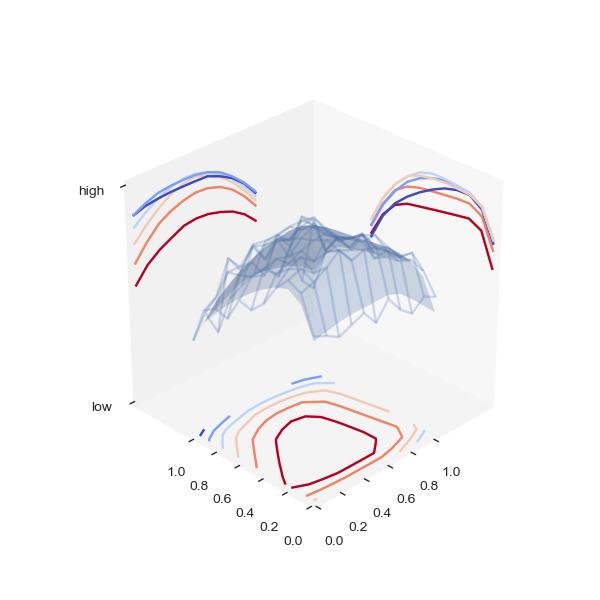

In [25]:
plt.show()